In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import pandas as pd

In [4]:
data_path = '../data/'
files = []

#lists the total number of .wav files in /data/
for f in os.listdir(data_path):
    if f.endswith('.wav'):
        files.append(f)

print(f"Found {len(files)} .wav files. Preparing analysis.")

Found 8 .wav files. Preparing analysis.


In [45]:
#calculates the spectral centroid, spectral flatness, spectral rolloff, zero crossing rate, rms and mfcc for all files in /data/
results = []

for file_name in files:
    full_path = os.path.join(data_path, file_name)
    y, sr = librosa.load(full_path)
    
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    cent_mean = np.mean(cent)
  
    flat = librosa.feature.spectral_flatness(y=y)[0]
    flat_mean = np.mean(flat)
    
    zero = librosa.feature.zero_crossing_rate(y=y)[0]
    zero_mean = np.mean(zero)
    
    rms = librosa.feature.rms(y=y)[0]
    rms_mean = np.mean(rms)
    rms_max = np.max(rms)

    roll_85 = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)[0]
    roll_85_mean = np.mean(roll_85)
    roll_99 = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.99)[0]
    roll_99_mean = np.mean(roll_99)


    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=5)
    mfcc_means = np.mean(mfcc, axis=1)
   
 

    #store in dictionary
    row = {
        'filename': file_name,
        'avg_brightness': cent,
        'avg_flatness': flat_mean,
        'avg_smooth':  zero_mean,
        'avg_loudness' : rms_mean,
        'peak_loudness' : rms_max,
        '85_percent' : roll_85_mean,
        '99_percent' : roll_99_mean,


        'mfcc_1' : mfcc_means[0],
        'mfcc_2' : mfcc_means[1]
    }
    results.append(row)

df = pd.DataFrame(results)
print(df)





            filename                                     avg_brightness  \
0           Meow.wav  [1177.102546335903, 1220.6969548248742, 1248.5...   
1      Low Drone.wav  [4651.697434666019, 390.0787246538484, 316.825...   
2        Ringing.wav  [8371.924586539684, 8371.755646925132, 8371.41...   
3  Glass Shatter.wav  [5226.149646034943, 5881.215000558035, 6953.20...   
4          Synth.wav  [2815.3914886096513, 3069.2796674100323, 3286....   
5   Car Breaking.wav  [5148.722304529699, 5561.892122818996, 5674.54...   
6    Racquet Hit.wav  [4893.628649372509, 3891.0807010218014, 2710.1...   
7      Bass Drum.wav  [2170.19085460473, 1432.1125230160364, 324.449...   

   avg_flatness  avg_smooth  avg_loudness  peak_loudness   85_percent  \
0      0.003150    0.093896      0.138755       0.414607  3489.182384   
1      0.000277    0.011732      0.077042       0.312767   217.988915   
2      0.131637    0.589513      0.191732       0.355623  7192.979825   
3      0.184680    0.481348     

In [ ]:
#Some prediction

def sound_prediction(row):

    impact_ratio = row['peak_loudness'] / (row['avg_loudness'] + 1e-6)

    #Identifying high energy sharp impact objects (glass ect)
    #High brightness + high percussive texture + high transient spike
    if row['avg_smooth'] > 0.05 and row['avg_brightness'] > 4000 and impact_ratio > 5:
        return "Glass/Sharp Impact"
   
    #Identifying noisy textures (hiss or wind ect)
    #High flatness + low dynamic range
    elif row['avg_flatness'] > 0.1 and impact_ratio < 2:
        return "Stationary"
    #Identifying high resonance sounds (high drone ect)
    #High brightness and high impact
    elif row['avg_brightness'] > 2000 and impact_ratio > 1.8:
        return "Resonant Hit"
    #Identifying pure tonal sounds (Synth or bell ect)
    #Low flatness + mfcc shapes
    elif row['avg_flatness'] < 0.05 and row['avg_brightness'] > 1000:
        return "Tonal"

    #Identifying low percussion (kick drum ect)
    #Low brightness + high energy spike
    elif row['avg_brightness'] < 1000 and row['peak_loudness'] > 0.4:
        return "Low percussion"
    else:
        return "Unknown/Complex"
    
df['prediction'] = df.apply(sound_prediction, axis=1)
print(df[['filename', 'prediction']])

            filename          prediction
0           Meow.wav               Tonal
1      Low Drone.wav     Unknown/Complex
2        Ringing.wav          Stationary
3  Glass Shatter.wav  Glass/Sharp Impact
4          Synth.wav        Resonant Hit
5   Car Breaking.wav        Resonant Hit
6    Racquet Hit.wav        Resonant Hit
7      Bass Drum.wav      Low percussion


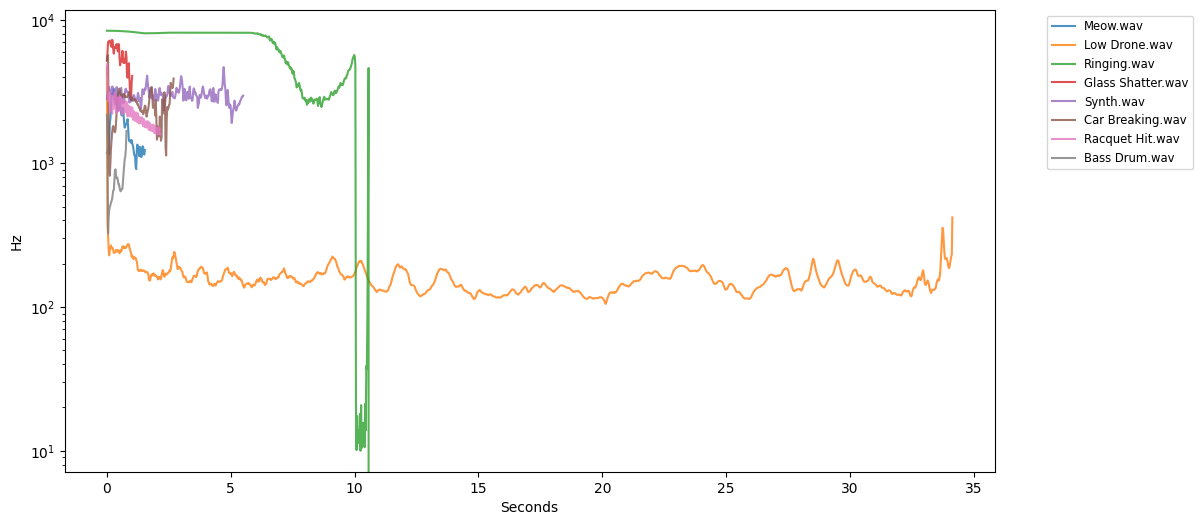

In [46]:
plt.figure(figsize=(12, 6))



for index, row in df.iterrows():
    #x-axis
    f = row['filename']
    cent = row['avg_brightness']
    time = librosa.frames_to_time(range(len(cent)), sr=sr)


    plt.semilogy(time, cent, label=f, alpha=0.8)

    


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.ylabel('Hz')
plt.xlabel('Seconds')
plt.show()